# Finding Differentially Expressed Genes

A breast cancer dataset is downloaded from Firehose (https://gdac.broadinstitute.org/). These are next generation sequncing data that are provided already normalized. 

## Loading the data

The dataset we are loading is called  "BRCA.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt". 

It looks like this: 

Hybridization REF TCGA.3C.AAAU.01A.11R.A41B.07 TCGA.3C.AALI.01A.11R.A41B.07 ...

gene_id                normalized_count             normalized_count        ...                      

?|100130426                 0.0000                       0.0000             ...        

This dataset has genes as rows and patients as columns. Patient IDs refer to TCGA IDs such as TCGA.3C.AAAU.01A.11R.A41B.07, etc. The top two lines of the file are header information, and we direct 'read.table' to skip these two lines since we only want the gene expressions to be placed in a dataframe we call 'mrnaNorm'. 
The first column of 'mrnaNorm'  contains the list of genes measured.

Since this is a large datset, you will have to wait until the '[*]' becomes a number in cell #1 to progress to the next cell.

In [1]:
mrnaNorm <- read.table("BRCA.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt", 
            header = F, fill = T, skip = 2)
class(mrnaNorm)

[1] "data.frame"

We also want the patient IDs in the first row, which is why we read only this first line and place it in a second dataframe callses 'mrnaIDs'. 
We also remove the first column with '[, -1]', the one entitled 'Hybridization REF', because it is not a patientID.

In [2]:
mrnaIDs <- read.table("BRCA.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt", 
            header = F, fill = T, nrows = 1)
class(mrnaIDs)
dim(mrnaIDs)
mrnaIDs <- mrnaIDs[, -1][, -1]  # remove the first solumn "Hybridization REF" which spans two columns because of the space between the two words
dim(mrnaIDs)

[1] "data.frame"

[1]    1 1214

[1]    1 1212

## Data preprocessing

Next we take a look at our data. Since this is a very large dataset, we are not going to display all the rows and columns, but only the first 5 rows and columns.
'mrnaNorm' contains 20,531 rows, representing the genes and their expressions, and 1213 columns (1212 subjects and the first column containing gene names).

In [3]:
dim(mrnaNorm)
dim(mrnaIDs)
mrnaIDs5 = mrnaIDs[,c(1,2,3,4,5)] # extract first 5 patientIDs
mrnaNorm5x5 = mrnaNorm[1:5, 1:5] # first 5 rows and columns 
head(mrnaIDs5, 2) # display first two rows
head(mrnaNorm, 2) # display first two rows
summary(mrnaNorm5x5) # summary statistics

[1] 20531  1213

[1]    1 1212

V3,V4,V5,V6,V7
TCGA-3C-AAAU-01A-11R-A41B-07,TCGA-3C-AALI-01A-11R-A41B-07,TCGA-3C-AALJ-01A-31R-A41B-07,TCGA-3C-AALK-01A-11R-A41B-07,TCGA-4H-AAAK-01A-12R-A41B-07


V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V1204,V1205,V1206,V1207,V1208,V1209,V1210,V1211,V1212,V1213
?|100130426,0.0000,0.0000,0.9066,0.0000,0.0000,0.0000,0,0.0000,0.0000,...,0.0000,0.0000,0,0.0000,0,0,0.0000,0.000,0.0000,0.0000
?|100133144,16.3644,9.2659,11.6228,12.0894,6.8468,3.9889,0,1.4644,15.3396,...,0.3992,4.3126,0,5.5624,0,0,14.3858,22.324,2.2638,6.8865


           V1          V2               V3                V4           
 ?|100130426:1   Min.   :  0.00   Min.   :  0.000   Min.   :   0.9066  
 ?|100133144:1   1st Qu.: 12.93   1st Qu.:  9.266   1st Qu.:   9.2294  
 ?|100134869:1   Median : 16.36   Median : 17.379   Median :  11.6228  
 ?|10357    :1   Mean   : 97.90   Mean   :132.059   Mean   : 307.3781  
 ?|10431    :1   3rd Qu.: 52.15   3rd Qu.: 69.755   3rd Qu.: 154.2974  
 ?|136542   :0   Max.   :408.08   Max.   :563.893   Max.   :1360.8341  
 (Other)    :0                                                         
       V5        
 Min.   :  0.00  
 1st Qu.: 11.08  
 Median : 12.09  
 Mean   :206.51  
 3rd Qu.:143.86  
 Max.   :865.54  
                 

The following instruction analyzes the patient IDs because the IDs can tell us whether a particular column is from a normal sample or a tumor sample. 
TCGA has data both from tumor samples and from normal samples taken from the same patient. This information can be found in the label of the column. For example in ID:
TCGA.3C.AAAU.01A.11R.A41B.07 
the type of sample is indicated in the 4th group: 01A.
Tumor types range from 01 - 09, normal types from 10 - 19 and control samples from 20 - 29.
Therefore we are extracting in the cell below this code indicating whether the sample is from normal or not. 
This group is the fourth in the ID character string, obtained with 'strsplit', and we get the two characters of interest by taking the first two characters with 'substr'.
We do this for all the IDs by applying with 'lapply' the same process to all the IDs in 'mrnaIDs'.

In [4]:
samp <- lapply(as.list(t(mrnaIDs)), function(t) substr(unlist(strsplit(t, "-"))[4], 1, 2))
# extract the sample type (tumor / normal), excluding the first column since it is a gene ID
sampleType <- as.data.frame(samp)
dim(sampleType)
# 1 1212

[1]    1 1212

Next we are going to count how many normals and how many tumor samples we have. 
The function 'unique' gives us the different types we have. 
The function 'table' calculates how many samples we have of each type. We see that we have 1100 of type '01' or '06' for tumor, and 112 of type '11' for normal.

In [5]:
unique(sampleType)
# extracts how many unique objects there are 

tab <- table(unlist(sampleType))
tab
# count how many of each type
#   01   06   11 
#  1093   7  112 

X.01.,X.01..1,X.01..2,X.01..3,X.01..4,X.01..5,X.01..6,X.01..7,X.01..8,X.01..9,...,X.01..1083,X.01..1084,X.01..1085,X.01..1086,X.01..1087,X.01..1088,X.01..1089,X.01..1090,X.01..1091,X.01..1092
01,01,01,01,01,01,01,01,01,01,...,01,01,01,01,01,01,01,01,01,01



  01   11   06 
1093  112    7 

We are going to associate a class of '1' for the tumor samples and of '0' for the normal samples. We check that we have 112 normals (class '0') and 1100 tumors (class '1').
We do this for all the types by applying with 'lapply' the same process to all the types in 'samp'.

In [6]:
sampClass <- lapply(samp, function(t) (if (t < 10) return("1") else return("0")))
mrnaClass <- as.data.frame(sampClass)
dim(mrnaClass)
table(unlist(sampClass))
#   0    1 
# 112 1100 

[1]    1 1212


   0    1 
 112 1100 

Since in some cases we may need the class as a number (and not a character), we create as well a list of classes as numbers.

In [7]:
sampClassNum <- lapply(samp, function(t) (if (t < 10) return(1) else return(0)))
mrnaClassNum <- as.data.frame(sampClassNum) 

Write a function that calculates a ranking of features (genes in this case) with the BSS/WSS method. You do not need to understand all the details - only to execute the following cell. This will make the bssWssFast function available for later processing.

In [8]:
bssWssFast <- function (X, givenClassArr, numClass=2)
# between squares / within square feature selection
{
	classVec <- matrix(0, numClass, length(givenClassArr))
	for (k in 1:numClass) {
		temp <- rep(0, length(givenClassArr))
		temp[givenClassArr == (k - 1)] <- 1
		classVec[k, ] <- temp
	}
	classMeanArr <- rep(0, numClass)
	ratio <- rep(0, ncol(X))
	for (j in 1:ncol(X)) {
		overallMean <- sum(X[, j]) / length(X[, j])
		for (k in 1:numClass) {
			classMeanArr[k] <- 
				sum(classVec[k, ] * X[, j]) / sum(classVec[k, ])
		}
	  classMeanVec <- classMeanArr[givenClassArr + 1]
	  bss <- sum((classMeanVec - overallMean)^2)
	  wss <- sum((X[, j] - classMeanVec)^2)
	  ratio[j] <- bss/wss
	}
      sort(ratio, decreasing = TRUE, index = TRUE)
}

## Feature selection with BSS/WSS

We are now ready to select features. 

We invoke the bssWSSFast function by passing to it the dataframe of gene expressions 'mrnaNorm' (all numeric, after excluding the first column, which is not numeric since it contains gene names) and another dataframe of classes associated with each sample. Note that we also transpose the 'mrnaNprm' dataframe because we watb to select genes, therefore the genes need to be feature / columns, while in 'mrnaNorm' genes are rows. By transposing 'mrnaNorm' and excluding the first column, we obtain a dataframe that looks like this ('t(mrnaNorm[, -1])'):

             gene1           gene2            gene3        ...
    
patient1   expression 1     expression 2      expression3    ...

patient2   expression 1     expression 2      expression3    ...


bssWssFast will return a dataframe with the features/genes column numbers ranked by decreasing order of importance according to bssWss ratio. 

bss$ix[1] refers to column 'ix' of bss, and could also be expressed by bss[,ix][1]. column 'ix' contains a list of indexes in 'mrnaNorm'.


In [9]:
bss <- bssWssFast(t(mrnaNorm[, -1]), t(mrnaClassNum), 2)
# returns a list with two elements: a list of bss/wss ratios in decreasing order bss[1] and a list of features bss[2]

bss$ix[1:50]
# show list of 50 ranked gene indexes

[1]  6418   308    59 12877   932 18528 15631 18014 16938 15575 13117  5228
[13]  9540  9622  9455 13808  7015  2857 13610 10327  2339  3394  3339  3606
[25] 10501  9529  3019 10110    72 13877  5393  3148    69  3020 18523   381
[37] 16998  9491 10434  9135  7907 15911 10983  6375  3343  1559 10633  1665
[49] 17267    71

We can then list the genes by their name as provided in the 'mrnaNorm' dataset, where the first column is the list of gene names. The names have two codes separated by character '|':

HUGO code
Entrez code

For example, FHL1|2273 is gene with HUGO code FHL1 and Entrez code 2273.

We will continue working on these genes in a future module.

In [10]:
genes <- mrnaNorm[bss$ix[1:50],1]
genes
# show list of 50 tanked gene names
# [1] FHL1|2273        ADAMTS4|9507     ABAT|18          PAG1|55824       ARHGAP1|392     
# [6] TP53TG3B|729355  SCRN3|79634      TIE1|7075        SNRPA|6626       SCCPDH|51097    
#[11] PCYT1B|9468      DSE|29940        LGI4|163175      LIX1L|128077     LCE3D|84648     
#[16] POTEE|445582     GIMAP2|26157     CABYR|26256      PLGLA|285189     LRRC57|255252   
#[21] C21orf33|8209    CDC14A|8556      CD300LF|146722   CEP57|9702       MAGEC2|51438    
#[26] LGALS3|3958      CAT|847          LOC647979|647979 ABCA8|10351      PPIL3|53938     
#[31] EFCAB1|79645     CCDC45|90799     ABCA5|23461      CAV1|857         TP53I3|9540     
#[36] ADRB1|153        SOD1|6647        LDLRAP1|26119    LYPLA1|10434     KLHL10|317719   
#[41] HLA-DPB1|3115    SGCG|6445        MLL2|8085        FGD4|121512      CD33|945        
#[46] BMS1|9790        MARCKSL1|65108   BTNL8|79908      SS18L2|51188     ABCA7|10347   


[1] FHL1|2273        ADAMTS4|9507     ABAT|18          PAG1|55824      
 [5] ARHGAP1|392      TP53TG3B|729355  SCRN3|79634      TIE1|7075       
 [9] SNRPA|6626       SCCPDH|51097     PCYT1B|9468      DSE|29940       
[13] LGI4|163175      LIX1L|128077     LCE3D|84648      POTEE|445582    
[17] GIMAP2|26157     CABYR|26256      PLGLA|285189     LRRC57|255252   
[21] C21orf33|8209    CDC14A|8556      CD300LF|146722   CEP57|9702      
[25] MAGEC2|51438     LGALS3|3958      CAT|847          LOC647979|647979
[29] ABCA8|10351      PPIL3|53938      EFCAB1|79645     CCDC45|90799    
[33] ABCA5|23461      CAV1|857         TP53I3|9540      ADRB1|153       
[37] SOD1|6647        LDLRAP1|26119    LYPLA1|10434     KLHL10|317719   
[41] HLA-DPB1|3115    SGCG|6445        MLL2|8085        FGD4|121512     
[45] CD33|945         BMS1|9790        MARCKSL1|65108   BTNL8|79908     
[49] SS18L2|51188     ABCA7|10347     
20531 Levels: ?|100130426 ?|100133144 ?|100134869 ?|10357 ?|10431 ... ZZZ3|26009

## Heatmap

Heatmaps are visualizations that represent the level of a variable across different samples or groups using different colors to represent levels.

In this particular example, we would like to represent the different expression levels of some of the genes selected above between normal and tumor samples. 

We will represent tumor samples in red and normals as blue at the top.

First we are going to select the top 100 genes ranked, and associate the class values 0/1 in a row at the bottom of mrnaSetClass.

Because selection by column is easier, we transpose the dataframe (inverse tows and columns).

We then separate the normals and the tumors in two datasets, selecting only 112 tumors so that we have an equal number of normals and tumors.

We then combine the two sets together.

We draw the heatmap by selecting several options:
 
1) we choose a color scheme as red for tumors and blue for normals for the top bar.

2) we apply the color scheme to the classes in the 'both' dataframe.

3) we draw the heatmp with options 'scale = "row"' to normalize the rows (gene values), 'col=topo.colors(100)' as a color scheme for the heatmap cells, and 'ColSideColors=groupColors' to specify the colors chosen for the side bars.

What we find on the heatmap is that it finds several groupins in the patients, mostly two groups of normals, and two groups of tumors. So this is interesting. We can also see some gene expressions characterizing the groups.


[1]  101 1212

[1] 112 101

[1] 1100  101

[1] 224 101

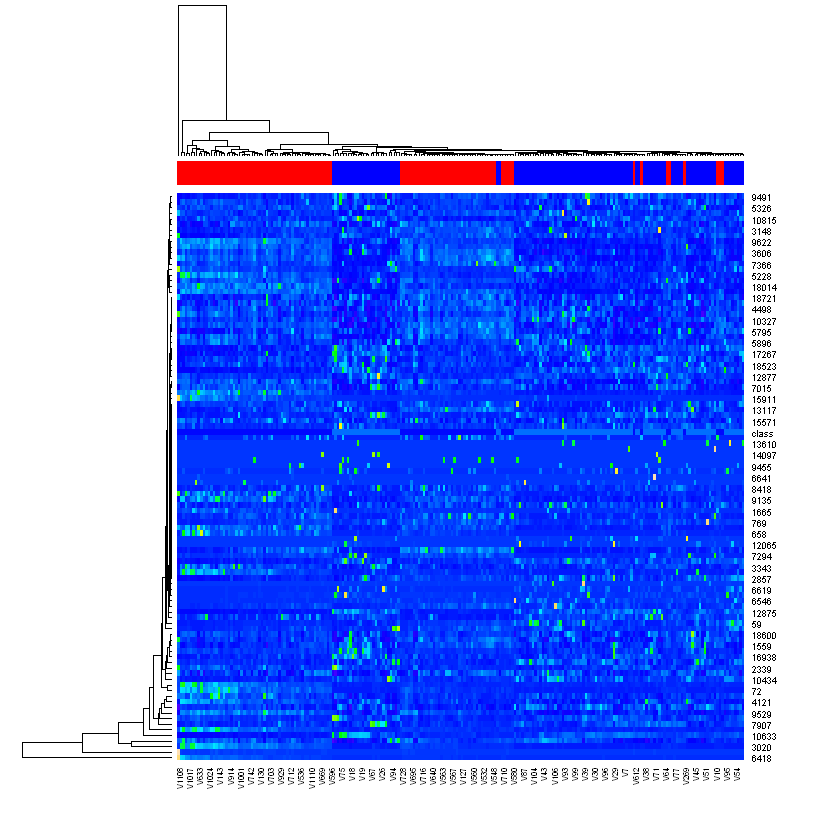

In [11]:
# merge class values into mrnaNorm as the last row  - after the genes and select only top 100 genes
mrnaSetClass <- rbind(mrnaNorm[bss$ix[1:100],-1], setNames(mrnaClassNum, names(mrnaNorm[,-1])))
dim(mrnaSetClass)
# 101  1212       101 genes as rows and 1212 patients as columns
# to select by class, transpose the matrix
transpose <- as.data.frame(t(mrnaSetClass))
colnames(transpose)[101] <- "class"
# select normals
normals <- subset(transpose, transpose$class == 0)
dim(normals)
#[1] 112 101
# select tumors
tumors <- subset(transpose, transpose$class == 1)
dim(tumors)
#[1] 1100 101
# combine them together
both <- rbind(normals, tumors[1:112,])
dim(both)
# select a color scheme - red for tumor and blue for normal
color.map <- function(class) { if (class==0) "#FF0000" else "#0000FF" } # red for tumor and blue for normal
# create heatmap
groupColors <- unlist(lapply(both$class, color.map))
heatmap(as.matrix(t(both)), scale = "row", col=topo.colors(100), ColSideColors=groupColors)